<a href="https://colab.research.google.com/github/INFJakZda/Emotion-Recognition/blob/master/reports/Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importowanie bibliotek

In [1]:
import argparse
import io
import json
import os
import re
import numpy as np
from matplotlib import pyplot as plt

from pylab import rcParams

import tensorflow as tf
print(tf.__version__)

import torch

from keras import optimizers
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

2.3.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Funkcje pomocnicze

## Definicja stałych

In [3]:
EMBEDDING_DIM=100
LSTM_DIM=120
NUM_CLASSES=4
MAX_SEQUENCE_LENGTH=200
DROPOUT=0.2
LEARNING_RATE=0.003
NUM_FOLDS=5
MAX_NB_WORDS=20000
BATCH_SIZE=200
NUM_EPOCHS=100

In [4]:
mainPath = '/content/drive/My Drive/Magisterka/'

trainDataPath = mainPath + 'train.txt'
devDataPath = mainPath + 'test.txt'
testDataPath = mainPath + 'test.txt'

solutionPath = mainPath + 'solution/'

gloveDir = mainPath + 'glove.6B.100d.txt'

label2emotion = {0: "others", 1: "happy", 2: "sad", 3: "angry"}
emotion2label = {"others": 0, "happy": 1, "sad": 2, "angry": 3}

## Funkcje pomocnicze

In [11]:
def getOneLayerLSTM(embeddingMatrix):
    """Constructs the architecture of the model
    Input:
        embeddingMatrix : The embedding matrix to be loaded in the embedding layer.
    Output:
        model : A basic LSTM model
    """
    embeddingLayer = Embedding(embeddingMatrix.shape[0],
                               EMBEDDING_DIM,
                               weights=[embeddingMatrix],
                               input_length=MAX_SEQUENCE_LENGTH,
                               trainable=False)
    model = Sequential(name="Jednowarstwowa architektura LSTM")
    model.add(embeddingLayer)
    model.add(LSTM(LSTM_DIM, dropout=DROPOUT))
    model.add(Dense(NUM_CLASSES, activation='sigmoid'))

    rmsprop = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)
    model.compile(loss='categorical_crossentropy',
                  optimizer=rmsprop,
                  metrics=['acc'])
    return model

In [12]:
def getDeepLSTM(embeddingMatrix):
    """Constructs the architecture of the model
    Input:
        embeddingMatrix : The embedding matrix to be loaded in the embedding layer.
    Output:
        model : A deep LSTM model
    """
    embeddingLayer = Embedding(embeddingMatrix.shape[0],
                               EMBEDDING_DIM,
                               weights=[embeddingMatrix],
                               input_length=MAX_SEQUENCE_LENGTH,
                               trainable=False)
    model = Sequential(name="Głęboka architektura LSTM")
    model.add(embeddingLayer)
    model.add(Bidirectional(LSTM(LSTM_DIM, dropout=DROPOUT, return_sequences=True)))
    model.add(Bidirectional(LSTM(LSTM_DIM, dropout=DROPOUT, return_sequences=True)))
    model.add(Bidirectional(LSTM(LSTM_DIM)))
    model.add(Dense(LSTM_DIM, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    rmsprop = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)
    model.compile(loss='categorical_crossentropy',
                  optimizer=rmsprop,
                  metrics=['acc'])
    return model

In [13]:
def preprocessData(dataFilePath, mode, eos=" <eos> "):
    """Load data from a file, process and return indices, conversations and labels in separate lists
    Input:
        dataFilePath : Path to train/test file to be processed
        mode : "train" mode returns labels. "test" mode doesn't return labels.
    Output:
        indices : Unique conversation ID list
        conversations : List of 3 turn conversations, processed and each turn separated by the <eos> tag
        labels : [Only available in "train" mode] List of labels
    """
    indices = []
    conversations = []
    labels = []
    with io.open(dataFilePath, encoding="utf8") as finput:
        finput.readline()
        for line in finput:
            # Convert multiple instances of . ? ! , to single instance
            # okay...sure -> okay . sure
            # okay???sure -> okay ? sure
            # Add whitespace around such punctuation
            # okay!sure -> okay ! sure
            repeatedChars = ['.', '?', '!', ',']
            for c in repeatedChars:
                lineSplit = line.split(c)
                while True:
                    try:
                        lineSplit.remove('')
                    except:
                        break
                cSpace = ' ' + c + ' '
                line = cSpace.join(lineSplit)

            line = line.strip().split('\t')
            if mode == "train":
                # Train data contains id, 3 turns and label
                label = emotion2label[line[4]]
                labels.append(label)

            conv = f'{eos}'.join(line[1:4])

            # Remove any duplicate spaces
            duplicateSpacePattern = re.compile(r'\ +')
            conv = re.sub(duplicateSpacePattern, ' ', conv)

            indices.append(int(line[0]))
            conversations.append(conv.lower())

    if mode == "train":
        return indices, conversations, labels
    else:
        return indices, conversations

In [14]:
def preprocessBertData(dataFilePath, mode, eos=" <eos> "):
    """Load data from a file, process and return indices, conversations and labels in separate lists
    Input:
        dataFilePath : Path to train/test file to be processed
        mode : "train" mode returns labels. "test" mode doesn't return labels.
    Output:
        indices : Unique conversation ID list
        conversations : List of 3 turn conversations, processed and each turn separated by the <eos> tag
        labels : [Only available in "train" mode] List of labels
    """
    indices = []
    conversations = []
    labels = []
    with io.open(dataFilePath, encoding="utf8") as finput:
        finput.readline()
        for line in finput:
            # Convert multiple instances of . ? ! , to single instance
            # okay...sure -> okay . sure
            # okay???sure -> okay ? sure
            # Add whitespace around such punctuation
            # okay!sure -> okay ! sure
            repeatedChars = ['.', '?', '!', ',']
            for c in repeatedChars:
                lineSplit = line.split(c)
                while True:
                    try:
                        lineSplit.remove('')
                    except:
                        break
                cSpace = ' ' + c + ' '
                line = cSpace.join(lineSplit)

            line = line.strip().split('\t')
            if mode == "train":
                # Train data contains id, 3 turns and label
                label = emotion2label[line[4]]
                labels.append(label)

            conv = f'{eos}'.join(line[1:4])

            # Remove any duplicate spaces
            duplicateSpacePattern = re.compile(r'\ +')
            conv = re.sub(duplicateSpacePattern, ' ', conv)

            indices.append(int(line[0]))
            conversations.append(conv)

    if mode == "train":
        return indices, conversations, labels
    else:
        return indices, conversations

In [15]:
def getMetrics(predictions, ground):
    """Given predicted labels and the respective ground truth labels, display some metrics
    Input: shape [# of samples, NUM_CLASSES]
        predictions : Model output. Every row has 4 decimal values, with the highest belonging to the predicted class
        ground : Ground truth labels, converted to one-hot encodings. A sample belonging to Happy class will be [0, 1, 0, 0]
    Output:
        accuracy : Average accuracy
        microPrecision : Precision calculated on a micro level. Ref - https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin/16001
        microRecall : Recall calculated on a micro level
        microF1 : Harmonic mean of microPrecision and microRecall. Higher value implies better classification  
    """
    # [0.1, 0.3 , 0.2, 0.1] -> [0, 1, 0, 0]
    discretePredictions = to_categorical(predictions.argmax(axis=1))

    truePositives = np.sum(discretePredictions * ground, axis=0)
    falsePositives = np.sum(np.clip(discretePredictions - ground, 0, 1), axis=0)
    falseNegatives = np.sum(np.clip(ground - discretePredictions, 0, 1), axis=0)

    print("True Positives per class : ", truePositives)
    print("False Positives per class : ", falsePositives)
    print("False Negatives per class : ", falseNegatives)

    # ------------- Macro level calculation ---------------
    macroPrecision = 0
    macroRecall = 0
    # We ignore the "Others" class during the calculation of Precision, Recall and F1
    for c in range(1, NUM_CLASSES):
        precision = truePositives[c] / (truePositives[c] + falsePositives[c])
        macroPrecision += precision
        recall = truePositives[c] / (truePositives[c] + falseNegatives[c])
        macroRecall += recall
        f1 = (2 * recall * precision) / (precision + recall) if (precision + recall) > 0 else 0
        print("Class %s : Precision : %.3f, Recall : %.3f, F1 : %.3f" % (label2emotion[c], precision, recall, f1))

    macroPrecision /= 3
    macroRecall /= 3
    macroF1 = (2 * macroRecall * macroPrecision) / (macroPrecision + macroRecall) if (
                                                                                             macroPrecision + macroRecall) > 0 else 0
    print("Ignoring the Others class, Macro Precision : %.4f, Macro Recall : %.4f, Macro F1 : %.4f" % (
        macroPrecision, macroRecall, macroF1))

    # ------------- Micro level calculation ---------------
    truePositives = truePositives[1:].sum()
    falsePositives = falsePositives[1:].sum()
    falseNegatives = falseNegatives[1:].sum()

    print(
        "Ignoring the Others class, Micro TP : %d, FP : %d, FN : %d" % (truePositives, falsePositives, falseNegatives))

    microPrecision = truePositives / (truePositives + falsePositives)
    microRecall = truePositives / (truePositives + falseNegatives)

    microF1 = (2 * microRecall * microPrecision) / (microPrecision + microRecall) if (
                                                                                             microPrecision + microRecall) > 0 else 0
    # -----------------------------------------------------

    predictions = predictions.argmax(axis=1)
    ground = ground.argmax(axis=1)
    accuracy = np.mean(predictions == ground)

    print("Accuracy : %.4f, Micro Precision : %.4f, Micro Recall : %.4f, Micro F1 : %.4f" % (
        accuracy, microPrecision, microRecall, microF1))
    return accuracy, microPrecision, microRecall, microF1

In [16]:
def getEmbeddingMatrix(wordIndex):
    """Populate an embedding matrix using a word-index. If the word "happy" has an index 19,
       the 19th row in the embedding matrix should contain the embedding vector for the word "happy".
    Input:
        wordIndex : A dictionary of (word : index) pairs, extracted using a tokeniser
    Output:
        embeddingMatrix : A matrix where every row has 100 dimensional GloVe embedding
    """
    embeddingsIndex = {}
    # Load the embedding vectors from ther GloVe file
    with io.open(gloveDir, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            embeddingVector = np.asarray(values[1:], dtype='float32')
            embeddingsIndex[word] = embeddingVector

    print('Found %s word vectors.' % len(embeddingsIndex))

    # Minimum word index of any word is 1. 
    embeddingMatrix = np.zeros((len(wordIndex) + 1, EMBEDDING_DIM))
    for word, i in wordIndex.items():
        embeddingVector = embeddingsIndex.get(word)
        if embeddingVector is not None:
            # words not found in embedding index will be all-zeros.
            embeddingMatrix[i] = embeddingVector

    return embeddingMatrix

# Kod wykonawczy LSTM

## Przetwarzanie danych LSTM

In [ ]:
trainIndices, trainTexts, trainLabels = preprocessData(trainDataPath, mode="train")
devIndices, devTexts, devLabels = preprocessData(devDataPath, mode="train")
testIndices, testTexts, testLabels = preprocessData(testDataPath, mode="train")

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(trainTexts)

trainSequences = tokenizer.texts_to_sequences(trainTexts)
devSequences = tokenizer.texts_to_sequences(devTexts)
testSequences = tokenizer.texts_to_sequences(testTexts)

In [ ]:
wordIndex = tokenizer.word_index
embeddingMatrix = getEmbeddingMatrix(wordIndex)

Found 400000 word vectors.


In [ ]:
dataTrain = pad_sequences(trainSequences, maxlen=MAX_SEQUENCE_LENGTH)
dataDev = pad_sequences(devSequences, maxlen=MAX_SEQUENCE_LENGTH)
dataTest = pad_sequences(testSequences, maxlen=MAX_SEQUENCE_LENGTH)

trainLabels = to_categorical(np.asarray(trainLabels))
devLabels = to_categorical(np.asarray(devLabels))
testLabels = to_categorical(np.asarray(testLabels))

## Budowa i ewaluacja modeli

### Jednowarstwowy LSTM

In [ ]:
model = getOneLayerLSTM(embeddingMatrix)

model.summary()

Model: "Jednowarstwowa architektura LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          1683200   
_________________________________________________________________
lstm (LSTM)                  (None, 120)               106080    
_________________________________________________________________
dense (Dense)                (None, 4)                 484       
Total params: 1,789,764
Trainable params: 106,564
Non-trainable params: 1,683,200
_________________________________________________________________


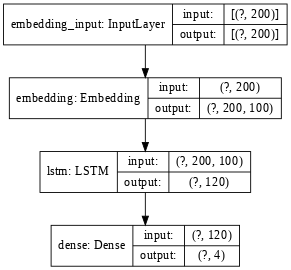

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [ ]:
history = model.fit(dataTrain, trainLabels, validation_data=(dataDev, devLabels), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
model.save(mainPath + 'EP%d_LR%de-5_LDim%d_BS%d.h5' % (NUM_EPOCHS, int(LEARNING_RATE * (10 ** 5)), LSTM_DIM, BATCH_SIZE))

Epoch 1/100
151/151 [==============================] - 10s 66ms/step - loss: 0.8679 - acc: 0.6491 - val_loss: 0.5086 - val_acc: 0.8067
Epoch 2/100
151/151 [==============================] - 9s 62ms/step - loss: 0.6003 - acc: 0.7677 - val_loss: 0.3874 - val_acc: 0.8640
Epoch 3/100
151/151 [==============================] - 9s 61ms/step - loss: 0.5137 - acc: 0.8058 - val_loss: 0.3497 - val_acc: 0.8766
Epoch 4/100
151/151 [==============================] - 9s 62ms/step - loss: 0.4518 - acc: 0.8293 - val_loss: 0.4391 - val_acc: 0.8461
Epoch 5/100
151/151 [==============================] - 9s 62ms/step - loss: 0.4131 - acc: 0.8463 - val_loss: 0.4484 - val_acc: 0.8308
Epoch 6/100
151/151 [==============================] - 9s 62ms/step - loss: 0.3834 - acc: 0.8556 - val_loss: 0.3229 - val_acc: 0.8913
Epoch 7/100
151/151 [==============================] - 9s 62ms/step - loss: 0.3693 - acc: 0.8607 - val_loss: 0.4034 - val_acc: 0.8584
Epoch 8/100
151/151 [==============================] - 9s 61m

In [ ]:
rcParams['figure.figsize'] = 8,6
plt.plot(history.history['acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='lower right')
plt.show()

In [ ]:
rcParams['figure.figsize'] = 8,6
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='right')
plt.show()

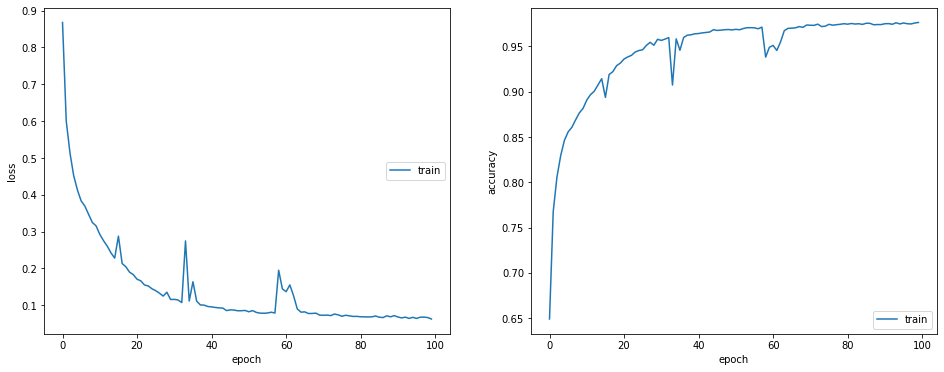

In [ ]:
rcParams['figure.figsize'] = 16, 6

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history.history['loss'])
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train'], loc='right')
ax2.plot(history.history['acc'])
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train'], loc='lower right')

In [ ]:
predictions = model.predict(dataTest, batch_size=BATCH_SIZE)
accuracy, microPrecision, microRecall, microF1 = getMetrics(predictions, testLabels)

True Positives per class :  [4146.  182.  173.  234.]
False Positives per class :  [180. 184. 238. 172.]
False Negatives per class :  [531. 102.  77.  64.]
Class happy : Precision : 0.497, Recall : 0.641, F1 : 0.560
Class sad : Precision : 0.421, Recall : 0.692, F1 : 0.523
Class angry : Precision : 0.576, Recall : 0.785, F1 : 0.665
Ignoring the Others class, Macro Precision : 0.4982, Macro Recall : 0.7060, Macro F1 : 0.5842
Ignoring the Others class, Micro TP : 589, FP : 594, FN : 243
Accuracy : 0.8595, Micro Precision : 0.4979, Micro Recall : 0.7079, Micro F1 : 0.5846


### Głęboki LSTM

In [ ]:
modelDeep = getDeepLSTM(embeddingMatrix)

modelDeep.summary()

Model: "Głęboka architektura LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          1683200   
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 240)          212160    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 240)          346560    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 240)               346560    
_________________________________________________________________
dense_1 (Dense)              (None, 120)               28920     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                7744      
_________________________________________________________________
dense_3 (Dense)              (None, 4)   

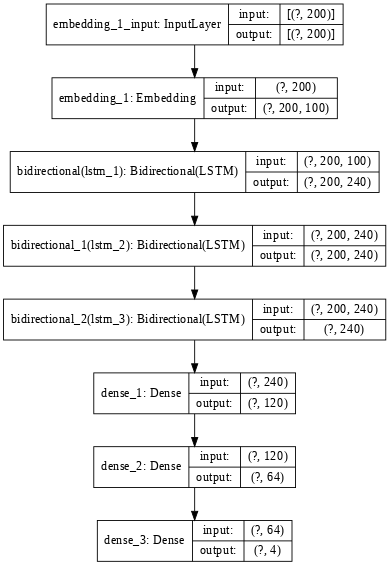

In [ ]:
tf.keras.utils.plot_model(modelDeep, show_shapes=True, dpi=64)

In [ ]:
historyDeep = modelDeep.fit(dataTrain, trainLabels, validation_data=(dataDev, devLabels), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
modelDeep.save(mainPath + 'EP%d_LR%de-5_LDim%d_BS%d_DEEP.h5' % (NUM_EPOCHS, int(LEARNING_RATE * (10 ** 5)), LSTM_DIM, BATCH_SIZE))

Epoch 1/100
151/151 [==============================] - 66s 437ms/step - loss: 1.0858 - acc: 0.5552 - val_loss: 0.4142 - val_acc: 0.8622
Epoch 2/100
151/151 [==============================] - 64s 423ms/step - loss: 0.6941 - acc: 0.7359 - val_loss: 0.4905 - val_acc: 0.8248
Epoch 3/100
151/151 [==============================] - 64s 425ms/step - loss: 0.5512 - acc: 0.7928 - val_loss: 0.4399 - val_acc: 0.8441
Epoch 4/100
151/151 [==============================] - 64s 424ms/step - loss: 0.4699 - acc: 0.8237 - val_loss: 0.4869 - val_acc: 0.8103
Epoch 5/100
151/151 [==============================] - 64s 422ms/step - loss: 0.4130 - acc: 0.8475 - val_loss: 0.4484 - val_acc: 0.8375
Epoch 6/100
151/151 [==============================] - 64s 424ms/step - loss: 0.3778 - acc: 0.8600 - val_loss: 0.3477 - val_acc: 0.8816
Epoch 7/100
151/151 [==============================] - 64s 424ms/step - loss: 0.3406 - acc: 0.8721 - val_loss: 0.3662 - val_acc: 0.8811
Epoch 8/100
151/151 [===========================

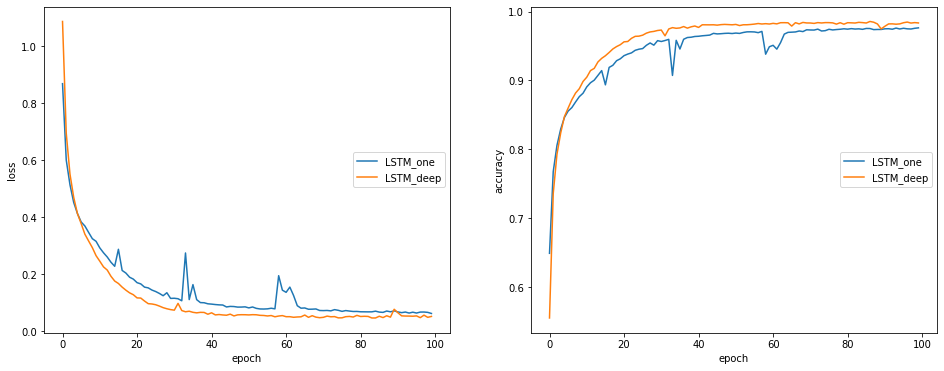

In [ ]:
rcParams['figure.figsize'] = 16, 6

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history.history['loss'])
ax1.plot(historyDeep.history['loss'])
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['LSTM_one', 'LSTM_deep'], loc='right')
ax2.plot(history.history['acc'])
ax2.plot(historyDeep.history['acc'])
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['LSTM_one', 'LSTM_deep'], loc='right')

In [ ]:
predictionsDeep = modelDeep.predict(dataTest, batch_size=BATCH_SIZE)
accuracyDeep, microPrecisionDeep, microRecallDeep, microF1Deep = getMetrics(predictionsDeep, testLabels)

True Positives per class :  [4176.  174.  172.  243.]
False Positives per class :  [181. 172. 198. 193.]
False Negatives per class :  [501. 110.  78.  55.]
Class happy : Precision : 0.503, Recall : 0.613, F1 : 0.552
Class sad : Precision : 0.465, Recall : 0.688, F1 : 0.555
Class angry : Precision : 0.557, Recall : 0.815, F1 : 0.662
Ignoring the Others class, Macro Precision : 0.5084, Macro Recall : 0.7054, Macro F1 : 0.5909
Ignoring the Others class, Micro TP : 589, FP : 563, FN : 243
Accuracy : 0.8649, Micro Precision : 0.5113, Micro Recall : 0.7079, Micro F1 : 0.5937


# Kod wykonawczy BERT

## Przygotowanie transformera

In [5]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [6]:
!pip install transformers

In [7]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [8]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P4


In [9]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
bertTokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [17]:
bertTrainIndices, bertTrainTexts, bertTrainLabels = preprocessBertData(trainDataPath, mode="train", eos=" [SEP] ")
bertDevIndices, bertDevTexts, bertDevLabels = preprocessBertData(devDataPath, mode="train", eos=" [SEP] ")
bertTestIndices, bertTestTexts, bertTestLabels = preprocessBertData(testDataPath, mode="train", eos=" [SEP] ")

In [18]:
print(' Original: ', bertTrainTexts[0])

# Print the sentence split into tokens.
print('Tokenized: ', bertTokenizer.tokenize(bertTrainTexts[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', bertTokenizer.convert_tokens_to_ids(bertTokenizer.tokenize(bertTrainTexts[0])))

print('Encode: ', bertTokenizer.encode(bertTrainTexts[0]))

 Original:  Don't worry I'm girl [SEP] hmm how do I know if you are [SEP] What's ur name ? 
Tokenized:  ['don', "'", 't', 'worry', 'i', "'", 'm', 'girl', '[SEP]', 'hmm', 'how', 'do', 'i', 'know', 'if', 'you', 'are', '[SEP]', 'what', "'", 's', 'ur', 'name', '?']
Token IDs:  [2123, 1005, 1056, 4737, 1045, 1005, 1049, 2611, 102, 17012, 2129, 2079, 1045, 2113, 2065, 2017, 2024, 102, 2054, 1005, 1055, 24471, 2171, 1029]
Encode:  [101, 2123, 1005, 1056, 4737, 1045, 1005, 1049, 2611, 102, 17012, 2129, 2079, 1045, 2113, 2065, 2017, 2024, 102, 2054, 1005, 1055, 24471, 2171, 1029, 102]


In [15]:
# max_len = 0

# # For every sentence...
# for sent in bertTrainTexts:

#     # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
#     input_ids = bertTokenizer.encode(sent, add_special_tokens=True)

#     # Update the maximum sentence length.
#     max_len = max(max_len, len(input_ids))

# print('Max sentence length: ', max_len)

Max sentence length:  168


In [19]:
encoded_dict = bertTokenizer.encode_plus(
                        bertTrainTexts[0],            # Sentence to encode.
                        add_special_tokens = True,    # Add '[CLS]' and '[SEP]'
                        max_length = 128,             # Pad & truncate all sentences.
                        truncation=True,
                        pad_to_max_length = True,
                        return_attention_mask = True, # Construct attn. masks.
                        return_tensors = 'pt',        # Return pytorch tensors.
                   )

print(bertTrainTexts[0])
print(encoded_dict['input_ids'])
print(encoded_dict['token_type_ids'])
print(encoded_dict['attention_mask'])

Don't worry I'm girl [SEP] hmm how do I know if you are [SEP] What's ur name ? 
tensor([[  101,  2123,  1005,  1056,  4737,  1045,  1005,  1049,  2611,   102,
         17012,  2129,  2079,  1045,  2113,  2065,  2017,  2024,   102,  2054,
          1005,  1055, 24471,  2171,  1029,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0, 

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


### Przetwarzanie danych Train

In [20]:
input_ids = []
attention_masks = []

# For every sentence...
for sent in bertTrainTexts:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = bertTokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        truncation=True,
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(bertTrainLabels)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


### Przetwarzanie danych Test

In [21]:
input_ids_test = []
attention_masks_test = []

# For every sentence...
for sent in bertTestTexts:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = bertTokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        truncation=True,
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_test.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_test.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_test = torch.cat(input_ids_test, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)
labels_test = torch.tensor(bertTestLabels)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [22]:
# Set the batch size.  
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids_test, attention_masks_test, labels_test)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [23]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

In [24]:
# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.99 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

29,858 training samples
  302 validation samples


In [25]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
# train_dataloader = DataLoader(
#             train_dataset,  # The training samples.
#             sampler = RandomSampler(train_dataset), # Select batches randomly
#             batch_size = batch_size # Trains with this batch size.
#         )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

dataLoader = DataLoader(
            dataset, # The validation samples.
            sampler = SequentialSampler(dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [26]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 4, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [52]:
# # Get all of the model's parameters as a list of tuples.
# params = list(model.named_parameters())

# print('The BERT model has {:} different named parameters.\n'.format(len(params)))

# print('==== Embedding Layer ====\n')

# for p in params[0:5]:
#     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# print('\n==== First Transformer ====\n')

# for p in params[5:21]:
#     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# print('\n==== Output Layer ====\n')

# for p in params[-4:]:
#     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [27]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [28]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(dataLoader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [29]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [30]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [31]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

test_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(dataLoader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(dataLoader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(dataLoader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    

    # Prediction on test set

    print('Predicting labels for test sentences...')

    # Tracking variables 
    predictions , true_labels = [], []

    # Predict 
    for batch in prediction_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(b_input_ids, token_type_ids=None, 
                            attention_mask=b_input_mask)

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

    accuracy, microPrecision, microRecall, microF1 = getMetrics(np.concatenate(predictions), to_categorical(np.asarray(bertTestLabels)))

    test_stats.append([accuracy, microPrecision, microRecall, microF1])

    print('    DONE.')



    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    50  of    943.    Elapsed: 0:00:37.
  Batch   100  of    943.    Elapsed: 0:01:14.
  Batch   150  of    943.    Elapsed: 0:01:52.
  Batch   200  of    943.    Elapsed: 0:02:30.
  Batch   250  of    943.    Elapsed: 0:03:07.
  Batch   300  of    943.    Elapsed: 0:03:45.
  Batch   350  of    943.    Elapsed: 0:04:22.
  Batch   400  of    943.    Elapsed: 0:05:00.
  Batch   450  of    943.    Elapsed: 0:05:37.
  Batch   500  of    943.    Elapsed: 0:06:15.
  Batch   550  of    943.    Elapsed: 0:06:53.
  Batch   600  of    943.    Elapsed: 0:07:30.
  Batch   650  of    943.    Elapsed: 0:08:08.
  Batch   700  of    943.    Elapsed: 0:08:45.
  Batch   750  of    943.    Elapsed: 0:09:23.
  Batch   800  of    943.    Elapsed: 0:10:00.
  Batch   850  of    943.    Elapsed: 0:10:38.
  Batch   900  of    943.    Elapsed: 0:11:16.

  Average training loss: 0.42
  Training epcoh took: 0:11:48

Running Validation...
Predicting labels for test

In [33]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=test_stats)

# Use the 'epoch' as the row index.
# df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,0,1,2,3
0,0.88,0.53,0.82,0.65
1,0.87,0.53,0.83,0.64
2,0.88,0.54,0.80,0.65
3,0.88,0.56,0.80,0.66


In [34]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.42,0.23,0.91,0:11:48,0:00:44
2,0.23,0.12,0.96,0:11:49,0:00:44
3,0.17,0.07,0.98,0:11:48,0:00:44
4,0.12,0.05,0.99,0:11:48,0:00:44


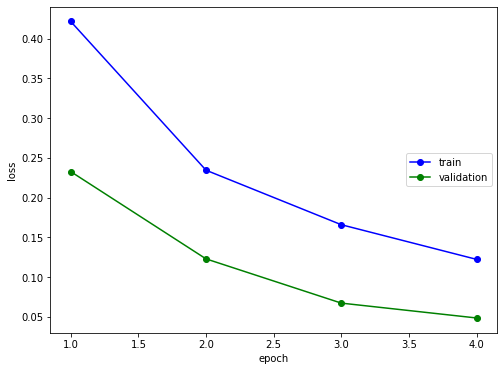

In [35]:
rcParams['figure.figsize'] = 8,6
# plt.plot(history.history['loss'])
plt.plot(df_stats['Training Loss'], 'b-o', label="Train")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')
plt.show()

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.39,0.34,0.9,0:05:47,0:00:11
2,0.23,0.33,0.9,0:05:46,0:00:11
3,0.15,0.39,0.9,0:05:45,0:00:11
4,0.10,0.46,0.9,0:05:43,0:00:11


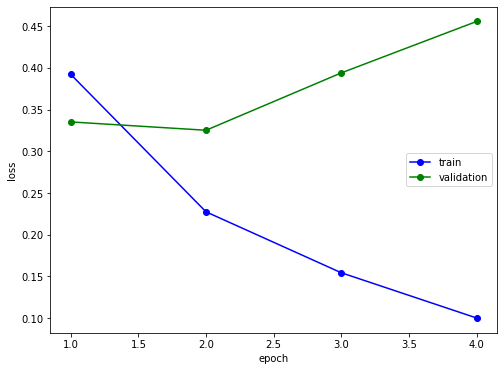

In [ ]:
rcParams['figure.figsize'] = 8,6
# plt.plot(history.history['loss'])
plt.plot(df_stats['Training Loss'], 'b-o', label="Train")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')
plt.show()

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 5,509 test sentences...
    DONE.


In [ ]:
accuracy, microPrecision, microRecall, microF1 = getMetrics(np.concatenate(predictions), to_categorical(np.asarray(bertTestLabels)))

True Positives per class :  [4244.  206.  199.  262.]
False Positives per class :  [100. 191. 126. 181.]
False Negatives per class :  [433.  78.  51.  36.]
Class happy : Precision : 0.519, Recall : 0.725, F1 : 0.605
Class sad : Precision : 0.612, Recall : 0.796, F1 : 0.692
Class angry : Precision : 0.591, Recall : 0.879, F1 : 0.707
Ignoring the Others class, Macro Precision : 0.5742, Macro Recall : 0.8002, Macro F1 : 0.6686
Ignoring the Others class, Micro TP : 667, FP : 498, FN : 165
Accuracy : 0.8915, Micro Precision : 0.5725, Micro Recall : 0.8017, Micro F1 : 0.6680


In [32]:
output_dir = mainPath + 'bert_32'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
bertTokenizer.save_pretrained(output_dir)

('/content/drive/My Drive/Magisterka/bert_32/vocab.txt',
 '/content/drive/My Drive/Magisterka/bert_32/special_tokens_map.json',
 '/content/drive/My Drive/Magisterka/bert_32/added_tokens.json')